<a href="https://colab.research.google.com/github/ingenum-ai/isvee_ML_for_epidemiology_course/blob/main/ISVEE_Day4_Session3%264_ModelBuilding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://raw.githubusercontent.com/ingenum-ai/isvee_ML_for_epidemiology_course/main/images/MarkdownContent_Header.png" width=900 alt="a pytorch workflow flowchat" width=900 alt="a pytorch workflow flowchat"/>


<br>
<br>

#Session 3 - PyTorch

##Building a 'simple' neural network






Machine learning and deep learning take data from the past, build an algorithm (like a neural network) to discover patterns and then use these patterns to predict the future.

<br>
<br>

*Simple enough, heh...?!*

<br>
<br>

In this exercise we are going to build a simple nueral network using the 'Feedlot' dataset that we have been working with earlier in the course.


The script is laid out in Markdown text and code chunks in this notebook below. Work through each of these sections before attempting the questions. We will build our model before lunch and then fit and evaluate it after lunch.

&nbsp;



## Model building workflow

In this module we're going to cover a typical PyTorch workflow.

<br>

<img src="https://raw.githubusercontent.com/ingenum-ai/isvee_ML_for_epidemiology_course/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat" width=900 alt="a pytorch workflow flowchat"/>

Image by drmbourke

<br>
<br>

For now, we'll use this workflow to predict a a dichotmous outcome (bulling2) using a single categorical input (treatment_protocol) but the workflow steps is repeatable and pretty applicable to almost all circumstances.

<br>

Specifically, we're going to cover:



| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to import the Feedlot dataset |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. |
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, so finally, we'll cover that too. |


<br>
<br>



## Where can I get help?

Ask a course coordinators, of course, but before you do so, try to look back through the notes and preceding steps and/or use 'Google's Gemini AI' that accompanies each notebook. It is a useful resource but does not know everything!

All of the materials and data for this course are [available on GitHub](https://github.com/ingenum-ai/isvee_ML_for_epidemiology_course).

There is extra reading and useful links included at the end of each notebook

There's also the [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch.


<br>
<br>



##Let's import what we'll need for this module.

Just like R, we'll import the libraries we need first up here. It is tidier and avoids confusion later.

We're going to chiefly use [PyTorch](https://pytorch.org/) `torch` with a little help from [scikit-learn](https://scikit-learn.org/stable/) `sklearn`.

We will also use `numpy`, `pandas` and `matplotlib` libraries. `pandas` is a Python library that helps us use dataframes and `matplotlib` helps plotting a displaying our data




In [2]:
# Import libraries for exercise

import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# pytorch
#!pip install torch
import torch
from torch import nn                      # nn contains all of PyTorch's building blocks for neural networks
from torch import Tensor                  # tensor node in the computation graph

import torch.autograd as autograd         # computation graph
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace       # hybrid frontend decorator and tracing jit

#scikit
#!{sys.executable} -m pip install scikit-learn==1.3.0
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold




# Check PyTorch version
torch.__version__

'2.5.0+cu121'

## 1. Data (preparing and loading)

We are using numerical epidemiological data because, honestly, that is what we are used to but data machine learning can use anything that can be converted to numbers: images of any kind, videos, audio files, protein structures, text and more. We won't have a chance to play with these all today but I have included some links to some online resources that can take you through these processes. In each case, everything comes down to numbers!


Machine learning is a game of two parts:
1. Turn your data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.





###Model data

In the ISVEE Day 4 Github repository there is a dataset that contains a subset of the feedlot data set


To save time, we have selected a limited number of feilds from the original datset and red it into a python notebook (Colab) datafile. You can see the code used to do this [here](https://github.com/ingenum-ai/isvee_ML_for_epidemiology_course/blob/main/Copy_of_ISVEE_Read_Compile_FeedlotData.ipynb)

Run the next chunk of code to mount your google drive and import the data. The head function shows you the top five lines, much as R does.

You will see that we are only going to use five selcted columns from the original data.


In [ ]:
# Import vet data

# Define the URL of the CSV file (updated)
url = "https://raw.githubusercontent.com/ingenum-ai/isvee_ML_for_epidemiology_course/main/data/feedlot_tensor.csv"

# Read the CSV file into a pandas DataFrame
df1 = pd.read_csv(url)

# Display the first few rows of the DataFrame to verify
df1.head()


,buller2,ind_weight,ind_month,ind_season,treatment_protocol
0,0,406,2021-01,Summer,Control
1,0,440,2021-01,Summer,AB11
2,0,363,2021-01,Summer,AB11
3,1,359,2021-01,Summer,ANA10
4,1,393,2021-01,Summer,AB11


### Split data into training and test sets

Great, we've got some data.

Before we build a model we need to split it up.

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

<br>

For now, we'll just use a training and test set, this means we'll have one dataset for our model to learn on as well as one to be evaluated on. It is best to keep these both seperated right at the beginning.

<br>

We want our model to learn from training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.

<br>


For categorical data we want each dataset to be representative of each input variable (i.e.  `treatment_protocol` in this case) so we will first stratify the raw data to accomplish this.

For this we shall use a useful module from the scikit library, principaly the `OneHotEncoder` function from the `sklearn.preprocessing` module.

> `OneHotEncoder` converts categorical data into a format that can be used in machine learning models. Instead of encoding categories with integers (which can imply an unwanted ordinal relationship), OneHotEncoder creates a binary (0 or 1) column for each category. For instance, if a dataset includes a column for “Color” with values “Red,” “Blue,” and “Green,” OneHotEncoder will create three new binary columns, one for each color, marking a “1” in the respective column if the color matches and “0” otherwise. This approach prevents the model from interpreting any ordinal relationship among the categories, which is critical for many algorithms to perform correctly.

In [ ]:
# Stratify raw dataset

encoder = OneHotEncoder(sparse_output=False)

feature_set = df1['treatment_protocol'].values.reshape(-1, 1)
feature_set_encoded = encoder.fit_transform(feature_set)

target = df1['buller2'].values


In [ ]:
# Stratify raw dataset with more features

encoder = OneHotEncoder(sparse_output=False)

# Use a list of column names to select multiple columns
feature_set = df1[['treatment_protocol', 'ind_weight', 'ind_season']].values

# Fit and transform the selected features
feature_set_encoded = encoder.fit_transform(feature_set)

target = df1['buller2'].values # assuming 'buller2' is your target variable

OK, now we're ready to split our data into 80% training and 20% test data.

In [ ]:
# Split raw dataset

dataset_split = train_test_split(*[feature_set_encoded, target],
                                 test_size=0.2,
                                 stratify=target,
                                 random_state=42)

Lets take a look at at the shape and the class balance of our two feature datasets (`y_train` and `y_test`)...

In [ ]:
# Print the shape files

for i in dataset_split:
  print(i.shape) # X_train, X_test, y_train, y_test

# Create a library fo these datasets

data = {k:v for k, v in zip(['X_train', 'X_test', 'y_train', 'y_test'], dataset_split)}

# Check class balance of features

print(data['y_train'].sum()/len(data['y_train']))
print(data['y_test'].sum()/len(data['y_test']))


In [ ]:
# Plot a histogram of these data

X_train, X_test, y_train, y_test = dataset_split

# Choose a feature to plot (e.g., feature 0)
feature_index = 0

plt.figure(figsize=(8, 6))
plt.hist(X_train[:, feature_index], bins=20, alpha=0.5, label="Training Data")
plt.hist(X_test[:, feature_index], bins=20, alpha=0.5, label="Testing Data")
plt.xlabel(f"Feature {feature_index}")
plt.ylabel("Frequency")
plt.title(f"Histogram of Feature {feature_index}")
plt.legend()
plt.show()




**Great. This looks good heh!**

Now we have a training dataset (`X`) and a feature set (`y`). The numbers approximate an 80:20 split and the representation of `treatment_protocols` is almost identical between the datasets.

<br>

To keep things tidy, we have also created a 'dictionary' of these datasets called `data` so that we can call them easily. In Python, `{ ... }` create a dictionary comprehension, which is a concise way to create a new dictionary.


###Convert these data to tensors

Now, lets do what we were practicing in Session 2 and convert these dataframes to tensors.



In [ ]:
# Convert to tensors

tensors = {k:torch.tensor(v, dtype=torch.long) for k,v in data.items()}

X_train = tensors['X_train'].type(torch.float32)
X_test = tensors['X_test'].type(torch.float32)
y_train = tensors['y_train'].type(torch.float32)
y_test = tensors['y_test'].type(torch.float32)


**Well done! This is a big step.**

We have called the PyTorch `torch.tensor` function which is where the magic happens. It takes the value (v) and converts it into a PyTorch tensor using the `torch.tensor()` function.

It's like saying, "Give me all the keys and their corresponding values from the dictionary."

`for k, v in...` is a loop that goes through each key-value pair. k represents the key, and v represents the value.

`dtype=torch.long` specifies that the tensor should have an integer data type.

`k: ...: This assigns the newly created tensor to the key (`k`) in the tensors dictionary.

<br>
<br>


Take a look at the tensors by simply calling the `tensor` dictionary

Count the square brackets and familiarise yourself with the shape of each tensor.

In [ ]:
# call the tensor dictinary

tensors

**Beautiful!**

<br>


Ones and zeros because we created dummy variables of each treatment_protocol

 Now we're going to move towards building a model that can learn the relationship between `X` (**features**) and `y` (**labels**).

We've got samples for training (`X_train` & `y_train`) and samples for testing (`X_test` & `y_test`).

The model we create is going to try and learn the relationship between `X_train` & `y_train` and then we will evaluate what it learns on `X_test` and `y_test`.



## 2. Build model

Now we've got some data, let's build a model to use the treatment protocol to predict the odds of an animal bulling.

<br>
<br>

**We'll write the code first and then explain everything.**

<br>
<br>

> **Resource:** We'll be using Python classes to create bits and pieces for building neural networks. If you're unfamiliar with Python class notation, I'd recommend reading [Real Python's Object Orientating programming in Python 3 guide](https://realpython.com/python3-object-oriented-programming/) a few times.

Let's replicate a standard logistic regression model using pure PyTorch.

In [ ]:
# Create a logisitic regression model class using the training data

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.linear = nn.Linear(input_size, 1)

# Forward defines the computation in the model
    def forward(self, x):
        return torch.sigmoid(self.linear(x))



**What have we just done?**

Alright there's a fair bit going on above but let's break it down bit by bit.

<br>

We have created a class `LogisticRegressionModel` that inherits from nn.Module, which is the base class for all neural network modules in PyTorch.

<br>

We then initialised the model using `__init__`

This is the constructor of the class. `super().__init__()` calls the constructor of the parent class (nn.Module).

`self.linear = nn.Linear(input_size, 1)` creates a linear layer that takes input_size features as input and produces a single output. Input_size should be the number of features in your X_train data (in our case, 11).


`forward(self, x)` defines how the input data (x) flows through the model.

`torch.sigmoid(self.linear(x))` Passes the input (x) through the linear layer (self.linear(x)), and then the sigmoid function (torch.sigmoid) is applied to the output to get probabilities between 0 and 1, a characteristic of logistic regression.

<br>
<br>

**Huh?**

A logistic regression model, while often considered a simple neural network, has structure that you will recognise from graphical representations of neural networks:

> - *Input Layer*. This layer represents the features (independent variables) you're feeding into the model. It's not explicitly defined as a layer in the code but is implicitly present when you pass data to the model.
> - *Hidden Layer* (Single Layer). In a basic logistic regression, there's effectively a single hidden layer that performs a linear transformation on the input features using weights and biases. This layer isn't explicitly defined in the code either but is represented by the weight matrix and bias vector within the model.
> - *Activation Function*. A sigmoid (or logistic) activation function is applied to the output of the hidden layer. This function introduces non-linearity, allowing the model to learn complex relationships between features and the target variable. Again, this is imposed within the model's forward method.
> - *Output Layer*. The output of the sigmoid activation function is the model's prediction, representing the probability of the target variable belonging to a specific class (e.g., 0 or 1). This layer is also implicit and is the final result when you call the model with input data.

<br>

Make anymore sense?

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are
- [`torch.nn`](https://pytorch.org/docs/stable/nn.html)
- [`torch.optim`](https://pytorch.org/docs/stable/optim.html)
- [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and
- [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html).

For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

<br>

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). |
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

<br>
<br>

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data.

<br>
<br>


<img src="https://raw.githubusercontent.com/ingenum-ai/isvee_ML_for_epidemiology_course/main/images/03_ModelBuilding.jpg" width=900 alt="PyTorch model building" width=900 alt="pytorch model building"/>

<br>
<br>

> **Resource:** See more of these essential modules and their use cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).



###Inspecting the Structure of our Logistic Regression Model

Now that we've set up the foundation, let's instantiate our logistic regression model and examine its internal components using the `.parameters()` method.

This allows us to understand how the model is structured and access its learnable parameters.

In [ ]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Assuming your input size is, for example, 11:
input_size = tensors['X_train'].shape[1]  # Get input size from your training data

# Create an instance (instantiate) of the model, providing the input_size
model_0 = LogisticRegressionModel(input_size)

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

# Print the model's parameters
print("Model Parameters:")
for name, param in model_0.named_parameters():
    print(f"  {name}: {param.shape}")


Model Parameters:
  linear.weight: torch.Size([1, 364])
  linear.bias: torch.Size([1])


We can also get the state (what the model contains) of the model using [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict).

In [ ]:
# List named parameters
import copy
original_state = copy.deepcopy(model_0.state_dict())
print(original_state)

OrderedDict([('linear.weight', tensor([[ 0.0401,  0.0435, -0.0123,  0.0481, -0.0115,  0.0106, -0.0255,  0.0308,
          0.0462, -0.0385,  0.0456,  0.0098,  0.0387,  0.0071,  0.0253, -0.0074,
          0.0404,  0.0077, -0.0245,  0.0134, -0.0241, -0.0061, -0.0213,  0.0348,
         -0.0414, -0.0242, -0.0148, -0.0315,  0.0049, -0.0518,  0.0473, -0.0445,
          0.0405,  0.0087, -0.0170,  0.0324,  0.0082,  0.0423,  0.0057, -0.0165,
          0.0141, -0.0142,  0.0221,  0.0468,  0.0303, -0.0229,  0.0303,  0.0094,
          0.0266, -0.0319, -0.0519, -0.0203, -0.0402,  0.0430,  0.0151,  0.0217,
          0.0166, -0.0009,  0.0410, -0.0372,  0.0033, -0.0358,  0.0162, -0.0181,
          0.0161, -0.0109,  0.0435, -0.0311, -0.0313, -0.0313,  0.0471,  0.0175,
          0.0504, -0.0433, -0.0520, -0.0410, -0.0353,  0.0212,  0.0188,  0.0436,
         -0.0271, -0.0357,  0.0278, -0.0212,  0.0318, -0.0124,  0.0300, -0.0407,
         -0.0265,  0.0160,  0.0111, -0.0134,  0.0312,  0.0356, -0.0380, -0.028

Notice how `weights` and `bias` from `model_0.state_dict()` are assigned values

While you can technically set the weights and bias directly using `nn.Parameter` as we demonstrate earlier, it's generally not the recommended way when using `nn.Linear` for a logistic regression.

Here's why:

- **nn.Linear Already Handles It.** The nn.Linear layer already creates and manages its own weight and bias parameters internally. When you initialize nn.Linear(input_size, 11), it automatically creates the necessary weight and bias tensors with random initialization.

- **Potential Conflicts.** Manually setting weights and bias potentially conflicts with how nn.Linear handles its parameters.

<br>

Essentially we want to start from random parameters and get the model to update them towards parameters that fit our data best

Because our model starts with random values, right now it'll have poor predictive power.



### Making predictions using `torch.inference_mode()`


Before we unleash our logistic regression model on the training data, let's have a little fun and see what it predicts right out of the box! Think of it like asking a toddler to identify objects — they might not be right all the time, but it's fascinating to see how they think.

To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined.

In [ ]:
# Make predictions with model

with torch.inference_mode():
    y_preds = model_0(X_test)

print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 30017
Number of predictions made: 30017
Predicted values:
tensor([[0.4963],
        [0.5174],
        [0.5016],
        ...,
        [0.5302],
        [0.5098],
        [0.5088]])


**Hmm.**

The values stored in y_preds are the model's raw predictions, but what do they mean? Since we're working with logistic regression, these values represent probabilities. Specifically, they indicate the model's confidence that an input example belongs to the positive class (usually class 1).

Here's the decoding key:

- Closer to 1: The model believes the input is very likely to belong to the positive class.
- Closer to 0: The model thinks the input is probably part of the negative class (usually class 0).
- Around 0.5: The model is uncertain and essentially flipping a coin for its prediction.

> *Remember*, these predictions are made before any training. The model is essentially guessing based on its initial random parameters. As it learns from the data during training, these predictions will become more accurate and meaningful.

<br>

What we have done here is used `torch.inference_mode()` as a context manager (that's what the with `torch.inference_mode(): is`) to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the `forward()` method) faster.

<br>

To make the interpretation more intuitive, you can convert these probabilities into class predictions using a threshold (e.g., 0.5)

**Remeber, we can change this manually or use cross validation (if time allows)**




In [ ]:
# Convert initial probabilities to predictions - default to 0.5 but this is biologically meaningless

y_preds_classes = [1 if pred >= 0.5 else 0 for pred in y_preds]
print("Class Predictions:", y_preds_classes)

Class Predictions: [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

**OK.**

<br>

Notice how there's one prediction value per testing sample.

This is because of the kind of data we're using. For our logistic reg, one `X` value maps to one `y` value.

However, machine learning models are very flexible. You could have 100 `X` values mapping to one, two, three or 10 `y` values. It all depends on what you're working on.

Our predictions are still numbers on a page, let's visualize them with our `plot_predictions()` function we created above.

Confusion Matrix:
[[ 6374 20867]
 [  877  1899]]


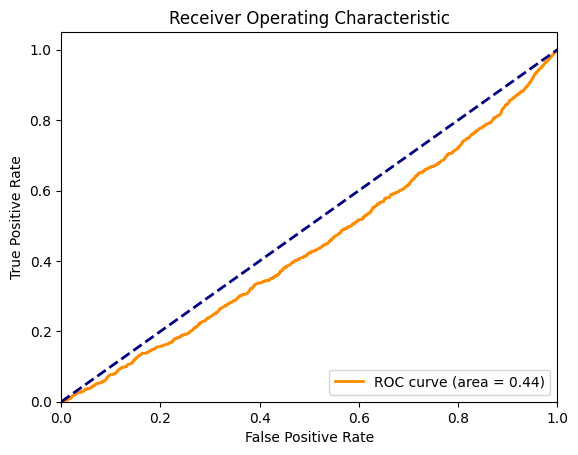

In [ ]:
# Using the true y_test labels, plot a contingency table or 'confusion matrix'


cm = confusion_matrix(y_test, y_preds_classes)

print("Confusion Matrix:")
print(cm)

model_0.eval()
with torch.inference_mode():
    y_preds_probs = model_0(X_test)  # Get predicted probabilities
    y_preds_probs = y_preds_probs.cpu().detach().numpy().ravel()  # Move to CPU & flatten

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test.cpu().numpy(), y_preds_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


**Not too flash, is it?**

However, this makes sense when you remember our model is just using random parameter values to make predictions.

> *Note,* while it is tempting to derive a sensitivity statistic here, a loss function monitors how well  model is learning and fitting the data and is typically preferred to straight forward Se.

<br>

**Time to improve this model, but how about some mornign tea first...?**


<br>



For those who have finished in plenty of time take a look at the questions below to extend your understanding...

In [ ]:
#Repeat the exercise able but now add another explanatory variable from the dataset.
#Save the model as df2 so that you can train both if required in teh next session.

# Alternative feature set
#features = ['treatment_protocol', 'ind_weight', 'ind_season']
#feature_set = df1[features]
#encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # handle_unknown='ignore' for unseen categories in test data
#feature_set_encoded = encoder.fit_transform(feature_set)

#...


Lets use ML to find the ideal cutpoint



In [ ]:
# Attempt to refine the prediction cut-point using K fold splits

kfold = KFold(n_splits=5, shuffle=True, random_state=42) # Example with 5 folds


In [ ]:
best_threshold = 0
best_youden_index = -1

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train model on X_train_fold, y_train_fold (using your existing training loop)

    # Get predictions on validation set:
    with torch.inference_mode():
        val_preds_probs = model_0(X_val_fold)
        val_preds_probs = val_preds_probs.cpu().detach().numpy().ravel()

    # Find optimal threshold for this fold using Youden's Index:
    fpr, tpr, thresholds = roc_curve(y_val_fold.cpu().numpy(), val_preds_probs)
    youden_indices = tpr - fpr
    optimal_threshold_fold = thresholds[np.argmax(youden_indices)]

    # Update best threshold if needed:
    if youden_indices[np.argmax(youden_indices)] > best_youden_index:
        best_youden_index = youden_indices[np.argmax(youden_indices)]
        best_threshold = optimal_threshold_fold

# The print statement should be at the same indentation level as the for loop
print(f"Best Threshold: {best_threshold}")

Best Threshold: 0.4784620404243469



<img src="https://raw.githubusercontent.com/ingenum-ai/isvee_ML_for_epidemiology_course/main/images/MarkdownContent_Header.png" width=900 alt="a pytorch workflow flowchat" width=900 alt="a pytorch workflow flowchat"/>


<br>
<br>


#Session 4 - PyTorch

##Training our 'simple' neural network

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to *parameters* as patterns), the `weights` and `bias` values were set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

Much of the time you won't know what the ideal parameters are for a model.

Instead, it's much more fun to write code to see if the model can try and figure them out itself.



### Creating a loss function and optimizer in PyTorch

Our logistic regression model is like a student eager to learn, but it needs a teacher to guide its progress. That's where the loss function and optimizer come in.

The rolls of these are:

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your model's predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). |

<br>

Depending on what kind of problem you're working on will dictate which loss function and what optimizer you should use to improve your model

<br>

**Loss Function: The Grading System**

The loss function acts as a strict but fair teacher, measuring how far off the model's predictions are from the actual answers (the ground truth). Think of it like a grading system; the lower the score (loss), the better the model is doing.

PyTorch provides a whole library of built-in loss functions, like different types of tests for various subjects:

- *Mean Absolute Error (MAE).* For regression problems, like predicting continuous values (e.g., house prices), MAE calculates the average difference between the predicted and actual values. It's like grading a math test based on the average error in calculations.

- *Binary Cross Entropy (BCE)* For our logistic regression (binary classification) task, BCE is the go-to choice. It measures how well the model's probability predictions align with the true class labels (0 or 1). It's like grading a true/false quiz based on how many answers the model gets right.

<br>

**Optimizer: The Learning Coach**

The optimizer is like a dedicated coach, guiding the model on how to improve its predictions based on the feedback from the loss function. It tells the model which parameters (weights and biases) to adjust and by how much to minimize the loss.

Think of it as a coach helping a student refine their technique based on their mistakes. The optimizer's goal is to find the best settings for the model's parameters to achieve the highest possible score (lowest loss).

<br>


##What loss function and optimiser should we choose?


For our problem, we are classifying features to predict an dichotomous outcome. So let us use BCE (under `torch.nn.BCELoss()`) as a loss function (as it measures the difference between predicted probabilities and true labels (0 or 1)) and Adams optimisation `torch.optim.Adam(params, lr)` which is considered a more efficient optimiser

`torch.optim.Adam(params, lr)` encodes:

- `params` as the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we looked at before).

- `lr` as the **learning rate** you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)).

<br>

*Right, that's a lot, let's see it in code...*

In [ ]:
# Create the loss function (Binary Cross Entropy)
loss_fn = nn.BCELoss()

# Create the optimizer (Adam)
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)  # You can adjust the learning rate as needed

### Creating an optimization loop in PyTorch

**Woohoo!**

Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **testing loop**).

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

<br>

*There will be a fair bit of code but nothing we can't handle!!*


### PyTorch training loop

For the training loop, we'll build the following steps:

<br>


| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` |
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

<br>


<img src="https://raw.githubusercontent.com/ingenum-ai/isvee_ML_for_epidemiology_course/main/images/03_ModelTraining.jpg" width=900 alt="PyTorch model training" width=900 alt="pytorch model training"/>

<br>

> **Note:** The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.
>
> And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb:
> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* computing the gradients of the loss with respect to every model parameter (`loss.backward()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).

For resources to help understand what's happening behind the scenes with backpropagation and gradient descent, see the extra-curriculum section.


### PyTorch testing loop

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the testing data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` |
| 3 | Calulate evaluation metrics (optional) | Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

<br>

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

<br>


<img src="https://raw.githubusercontent.com/ingenum-ai/isvee_ML_for_epidemiology_course/main/images/03_ModelTesting.jpg" width=900 alt="PyTorch model testing" width=900 alt="pytorch model testing"/>

<br>

Let's put all of the above together and train our model for 100 **epochs** (forward passes through the data) and we'll evaluate it every 10 epochs.


In [ ]:
#Lets do this in one!

# Reshape the target tensors before entering the training and testing loops
if y_train.dim() == 1:  # Check if y_train is 1-dimensional
    y_train = y_train.unsqueeze(1)  # Add an extra dimension if needed
elif y_train.dim() > 2:  # Check if y_train has more than 2 dimensions
    y_train = y_train.squeeze()  # Remove extra dimensions if needed

if y_test.dim() == 1:  # Check if y_test is 1-dimensional
    y_test = y_test.unsqueeze(1)  # Add an extra dimension if needed
elif y_test.dim() > 2:  # Check if y_test has more than 2 dimensions
    y_test = y_test.squeeze()  # Remove extra dimensions if needed


# Setting the Learning Stage: Planting the Seed
torch.manual_seed(42)  # Ensures consistent results, like planting a seed for a predictable harvest

# Training Journey: Embarking on the Epochs
epochs = 200  # Number of times the model will explore the training data

# Progress Tracker: Charting the Course
train_loss_values = []  # Recording the model's progress during training
test_loss_values = []  # Assessing the model's performance on unseen data
epoch_count = []  # Marking milestones along the way

# The Grand Loop: Guiding the Model's Learning
for epoch in range(epochs):
    # Training Phase: Sharpening the Skills
    model_0.train()  # Setting the model to training mode, like entering a practice arena

    # 1. Forward Pass: Making Predictions
    y_pred = model_0(X_train)  # The model takes its first steps, attempting to predict outcomes

    # 2. Loss Calculation: Evaluating Performance
    loss = loss_fn(y_pred, y_train)  # The teacher (loss function) assesses the model's predictions

    # 3. Optimizer Reset: Clearing the Path
    optimizer.zero_grad()  # The coach (optimizer) prepares the model for the next step

    # 4. Backpropagation: Learning from Mistakes
    loss.backward()  # The model reflects on its errors, seeking areas for improvement

    # 5. Parameter Update: Refining Skills
    optimizer.step()  # The coach guides the model, adjusting its parameters for better predictions

    # Testing Phase: Demonstrating Knowledge
    model_0.eval()  # Setting the model to evaluation mode, like entering the performance stage

    with torch.inference_mode():  # Ensuring the model's performance is unbiased
        # 1. Forward Pass: Applying Learned Knowledge
        test_pred = model_0(X_test)  # The model tackles unseen challenges, putting its knowledge to the test

        # 2. Loss Calculation: Measuring Performance
        test_loss = loss_fn(test_pred, y_test.type(torch.float))  # The teacher evaluates the model's performance on new data

        # Progress Report: Sharing the Achievements
        if epoch % 10 == 0:  # Reporting at regular intervals, like sharing progress at milestones
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | Training Loss: {loss:.4f} | Testing Loss: {test_loss:.4f}")

**Oh would you look at that!**

Looks like our loss is going down with every epoch, let's plot it to find out.

<br>


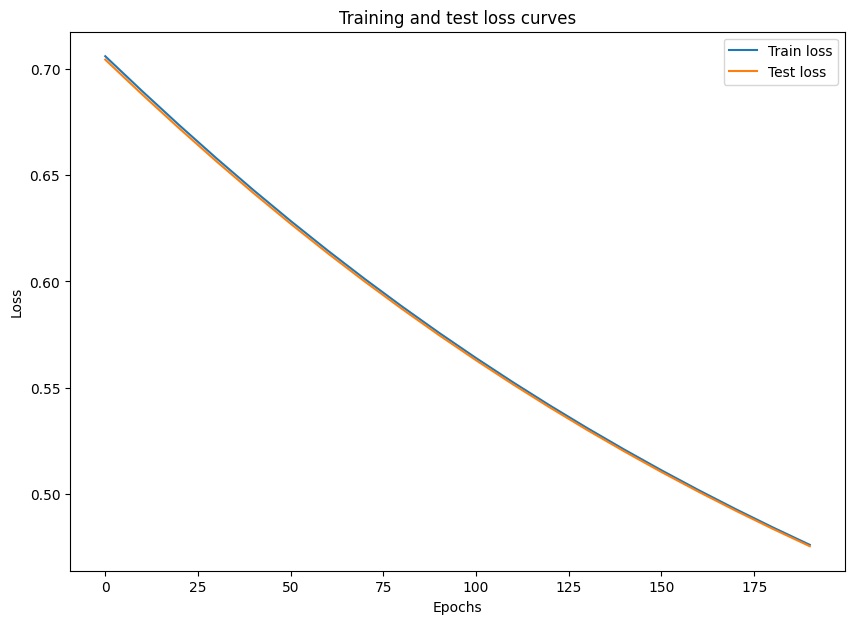

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 7))

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

*Managed to get a nice curve yet?*

**If not go back and try a different number of epochs in the code block above...**

<br>

The **loss curves** show the loss going down over time. Remember, loss is the measure of how *wrong* your model is, so the lower the better.

But why did the loss go down?

Well, thanks to our loss function and optimizer, the model's internal parameters (`weights` and `bias`) were updated to better reflect the underlying patterns in the data.

Let's inspect our model's [`.state_dict()`](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html) to see how close our model gets to the original values we set for weights and bias.



In [ ]:
# Find the model's learned parameters
print("The original values for weights and bias are:")
print(original_state)

print("The model learned the following values for weights and bias:")
print(model_0.state_dict())

*This is encouraging!*

The parameters have changed and assuming a greater difference from 0.5, then changed for the better too!

In [ ]:
# Re-run ROC curve calculation and plot

model_0.eval()  # Set the model to evaluation mode
with torch.inference_mode():
    y_preds_probs = model_0(X_test)  # Get predicted probabilities
    y_preds_probs = y_preds_probs.cpu().detach().numpy().ravel()  # Move to CPU & flatten

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test.cpu().numpy(), y_preds_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (After Training)')
    plt.legend(loc="lower right")
    plt.show()

**Phew - This is beginning to improve the prediction**



> **Exercise:** Try changing the `epochs` value above to 200, what happens to the loss curves and the weights and bias parameter values of the model?

It'd likely never guess them *perfectly* (especially when using more complicated datasets) but that's okay, often you can do very cool things with a close approximation.

This is the whole idea of machine learning and deep learning, **there are some ideal values that describe our data** and rather than figuring them out by hand, **we can train a model to figure them out programmatically**.

## 4. Making predictions with a trained PyTorch model (inference)



Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)

  y_preds = model_0(X_test)
y_preds

tensor([[0.3243],
        [0.3438],
        [0.3313],
        ...,
        [0.3546],
        [0.3369],
        [0.3356]])

Nice! We've made some predictions with our trained model, now how do they look?

In [ ]:
from sklearn.metrics import accuracy_score

y_test_np = np.array(y_test)  # Convert y_test to a NumPy array

# Now calculate accuracy
accuracy = accuracy_score(y_test_np, y_preds_classes)
print("Accuracy:", accuracy)

Accuracy: 0.2756104873904787


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(predictions=None):
    """Plots predictions against actual values."""

    # Assuming y_test is defined in your scope:
    y_test_np = y_test.cpu().detach().numpy()  # Detach from computation graph

    # Assuming y_preds is defined in your scope:
    y_preds_probs = predictions.cpu().detach().numpy().ravel()

    # Ensure they have the same length
    min_len = min(len(y_test_np), len(y_preds_probs))
    y_test_np = y_test_np[:min_len]
    y_preds_probs = y_preds_probs[:min_len]

    # Create a scatter plot of predictions vs. true labels
    plt.scatter(y_test_np, y_preds_probs)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Probability')
    plt.title('Predictions vs. True Labels')
    plt.show()

    plot_predictions(predictions=y_preds)

*OK!*

Those dots are looking pretty meaningless but it is a logisitcal regression afterall!

Let's get onto saving and reloading a model in PyTorch.

In [ ]:
# Convert trained probabilities to predictions

y_preds_classes_trained = [1 if pred >= 0.1 else 0 for pred in y_preds]
print("Class Predictions:", y_preds_classes_trained)

Class Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Using the true y_test labels, plot a contingency table or 'confusion matrix'

cm_trained = confusion_matrix(y_test, y_preds_classes_trained)

print("Confusion Matrix:")
print(cm_trained)

Confusion Matrix:
[[    0 27241]
 [    0  2776]]


## 5. Saving and loading a PyTorch model




If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it.

Or maybe you'd like to save your progress on a model and come back and load it back later.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the [PyTorch saving and loading models guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| PyTorch method | What does it do? |
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialized object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  |
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. |

> **Note:** As stated in [Python's `pickle` documentation](https://docs.python.org/3/library/pickle.html), the `pickle` module **is not secure**. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.


### Saving a PyTorch model's `state_dict()`

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

1. We'll create a directory for saving models to called `models` using Python's `pathlib` module.
2. We'll create a file path to save the model to.
3. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

> **Note:** It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.


In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1744 Oct 30 02:48 models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

Why not save the entire model?

[Saving the entire model](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model) rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation (italics mine):

> The disadvantage of this approach *(saving the whole model)* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
>
> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by creating another instance of `LogisticRegressionModel()`, which is a subclass of `torch.nn.Module` and will hence have the in-built method `load_state_dict()`.

In [ ]:
# Lets also

input_size = 11

# Instantiate a new instance with the input_size
loaded_model_0 = LogisticRegressionModel(input_size=input_size)

# Load the state_dict of our saved model
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<ipython-input-59-3a939d849fd0>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

Excellent! It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

Remember the rules for performing inference with PyTorch models?

If not, here's a refresher:

<details>
    <summary>PyTorch inference rules</summary>
    <ol>
      <li> Set the model in evaluation mode (<code>model.eval()</code>). </li>
      <li> Make the predictions using the inference mode context manager (<code>with torch.inference_mode(): ...</code>). </li>
      <li> All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).</li>
    </ol>
</details>



In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

Now we've made some predictions with the loaded model, let's see if they're the same as the previous predictions.

In [ ]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        ...,
        [True],
        [True],
        [True]])

Nice!

It looks like the loaded model predictions are the same as the previous model predictions (predictions made prior to saving). This indicates our model is saving and loading as expected.

> **Note:** There are more methods to save and load PyTorch models but I'll leave these for extra-curriculum and further reading. See the [PyTorch guide for saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models) for more.

## Other useful resources

* Read [What is `torch.nn`, really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard for a deeper understanding of how one of the most important modules in PyTorch works.
* Spend 10-minutes scrolling through and checking out the [PyTorch documentation cheatsheet](https://pytorch.org/tutorials/beginner/ptcheat.html) for all of the different PyTorch modules you might come across.
* Spend 10-minutes reading the [loading and saving documentation on the PyTorch website](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to become more familiar with the different saving and loading options in PyTorch.
* Spend 1-2 hours reading/watching the following for an overview of the internals of gradient descent and backpropagation, the two main algorithms that have been working in the background to help our model learn.
 * [Wikipedia page for gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)
 * [Gradient Descent Algorithm — a deep dive](https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21) by Robert Kwiatkowski
 * [Gradient descent, how neural networks learn video](https://youtu.be/IHZwWFHWa-w) by 3Blue1Brown
 * [What is backpropagation really doing?](https://youtu.be/Ilg3gGewQ5U) video by 3Blue1Brown
 * [Backpropagation Wikipedia Page](https://en.wikipedia.org/wiki/Backpropagation)
